# Goals

Understand the basic principles underlying:

- Classification
- Multilayer perceptrons
- Backpropagation

# TODO

The most important goal is to understand.

At each part of the notebook, you will find hyper-parameters. Your task is to change these hyper-parameters and study their effect.

1) The dataset

Visualize the data and understand the task.

Hyper-parameters to change: 
- size of the dataset (n_samples)
- shape of the circles (factor)
- strength of the noise (noise)
- number of examples per batch (batch_size)


2) The network

If you are in "advanced coding mode", fill in the gaps.

Hyperparameters to change:
- the size of the hidden layer (dim_h)
- the scale of the initial random weights (w)

3) Training and testing the network


Hyper-parameters to change: 
- number of epochs (n_epochs)
- learning rate (learning_rate)




# 0) Loading useful packages and modules

In [1]:
import numpy as np  # to handle operations on arrays of numbers, similar to matlab
import matplotlib.pyplot as plt  # to plot figures
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.optim
import sklearn as skl
import load_dataset as load  # home-made module with functions to load datasets

# 1) The dataset

We load the "circles" dataset.

For now, we set a batch_size of 1, meaning we will give the examples one by one to the network.

The loader gives us a train_loader and a test_loader, having 75 % and 25 % of the dataset examples respectively.

You can choose different "factor" values between the circles, and different "noise" levels.

If your computer is slow, you can reduce the number of examples n_samples.

In [23]:
batch_size = 1  # the number of examples per batch
train_loader, test_loader, dim_in, dim_out = load.load_circles(batch_size=batch_size, 
                                                               n_samples=1000, 
                                                               shuffle=True, 
                                                               noise=0., 
                                                               factor=0.5)

Let's look into the dataset.

We can plot it and look at some examples of inputs and targets.

Note that the inputs are of the class "tensor" from pytorch.

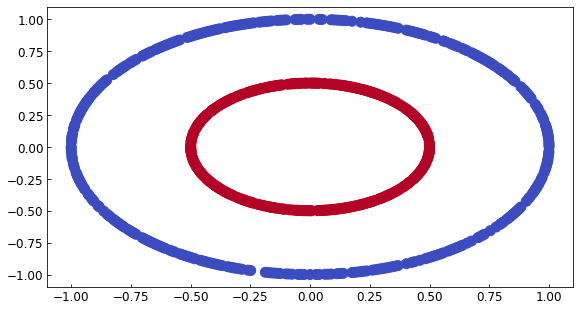

In [24]:
X = train_loader.dataset.data  # we take the DATA (here all dataset)
targets = train_loader.dataset.targets  # we take the TARGET (here all dataset)
ax = plt.subplot()
ax.scatter(X[:, 0], X[:, 1], c=targets, cmap=cm.coolwarm)
plt.show()

# 2) The network

We first code useful functions, then assemble them into a network.

We chose the ReLU as the activation function.

In [25]:
def relu(x):
    y = x.clone()
    y[x <0] = 0
    return y

In [26]:
def d_relu(x):
    y = torch.ones_like(x)
    y[x<0]=0
    return y

In [27]:
def softmax(y):
    z = torch.exp(y)/(torch.exp(y).sum(axis=-1)).unsqueeze(dim=-1)
    return z

Here we define the network. A multi layer perceptron with one hidden layer.

In [28]:
class multi_layer_perceptron():
    def __init__(self, dim_in, dim_h, dim_out, w):
        self.dim_in = dim_in # number of inputs
        self.dim_h = dim_h # number of hidden neurons
        self.dim_out = dim_out # number of outputs
        
        # Here we define the parameters (weights and biases) and initialize them randomly
        self.weights_1 = torch.randn(dim_in, dim_h) * w
        self.bias_1 = torch.randn(dim_h) * w
        self.weights_2 = torch.randn(dim_h, dim_out) * w
        self.bias_2 = torch.randn(dim_out) * w
        
    # The forward function is what the network does: what transformations are applied to the inputs.
    def forward(self, x):
        self.y_1 = torch.matmul(x, self.weights_1) + self.bias_1
        self.h = relu(self.y_1)
        y_2 = torch.matmul(self.h, self.weights_2) + self.bias_2
        return y_2
    
    # This function computes the gradients associated to each parameter
    def compute_grad(self, x, targets):
        y_2 = self.forward(x) # we apply the network
        p = softmax(y_2)
        targets = torch.nn.functional.one_hot(targets, num_classes=2).float()
        loss = - torch.dot(torch.log(p), targets) # cross entropy loss
        
        #Layer 2 of weights and biases
        self.dL_db2 = torch.zeros_like(self.bias_2)
        self.dL_dw2 = torch.zeros_like(self.weights_2)

        for j in range(self.dim_out):
            #dL_dy2[j] = p2[j] - target[j] 
            for i in range(self.dim_h):
                #dy2_dw2[i, j] = self.h[i]
                #dL_dw2[i, j] = dL_dy2[j] * dy2_dw2[j, j]
                self.dL_dw2[i, j] = (p[j] - targets[j]) * self.h[i]
                
            #dy2_db2[j] = 1
            #dL_db2[j] = dL_dy2[j] * dy2_db2[j]
            self.dL_db2[j] = (p[j] - targets[j]) * 1

        #Layer 1 of weights and biases
        self.dL_db1 = torch.zeros_like(self.bias_1)
        self.dL_dw1 = torch.zeros_like(self.weights_1)
        
        for j in range(self.dim_h):
            #dL_dh[j] = torch.dot(dL_dy2, self.weights_2[j, :])
            #dh_dy1[j] = d_relu(self.y_1[j])
            for i in range(self.dim_in):
                #dy1_dw1[i, j] = x[i]
                #dL_dw1[i, j] = dL_dh[j] * dh_dy1[j] * dy1_dw1[i, j]
                self.dL_dw1[i, j] = torch.dot(p - targets, self.weights_2[j, :]) * d_relu(self.y_1[j]) * x[i]
                
            #dy1_db1[j] = 1
            #dL_db1[j] = dL_dh[j] * dh_dy1[j] * dy1_db1[j]
            self.dL_db1[j] = torch.dot(p - targets, self.weights_2[j, :]) * d_relu(self.y_1[j]) * 1
            
        return loss
            
    # This function updates the parameters using the gradients
    def update_params(self, learning_rate):
        self.weights_1 -= learning_rate * self.dL_dw1 
        self.bias_1 -= learning_rate * self.dL_db1 
        self.weights_2 -= learning_rate * self.dL_dw2 
        self.bias_2 -= learning_rate * self.dL_db2 

        

We make a function to plot the results of the network on the task/

In [29]:
def plot_results(network, x, targets):
    y = network.forward(x)
    p = softmax(y)
    pred = y.argmax(dim=1) # the predicted class is the output neurons with the highest value
    idxs = torch.nonzero(((pred == targets[:]) == False)).squeeze() # indexes predicted in wrong class
    fig, ax = plt.subplots(1, 2)
    ax[0].scatter(x[:, 0], x[:, 1], c=p[:,1], cmap=cm.coolwarm, vmin=0, vmax=1) # proba to be class 1
    ax[0].set_title('Probability to be class 1')
    ax[1].scatter(x[:, 0], x[:, 1], c=pred, cmap=cm.coolwarm, vmin=0, vmax=1) # class
    ax[1].scatter(x[idxs, 0], x[idxs, 1], facecolors='none', edgecolor='green', linewidths=2) # misclassified
    ax[1].set_title('Predicted class (red = 1)')

We make a function to compute the accuracy on the task, i.e. the proportion of correctly classified examples.

In [30]:
def accuracy(network, x, targets):
    y = network.forward(x)
    p = softmax(y)
    pred = p.argmax(dim=-1)
    accuracy = (pred == targets).double().mean()
    return accuracy

We create a network suitable to solve the circles task. 

Hyperparameters to change:
- the size of the hidden layer (dim_h)
- the scale of the initial random weights (w)

In [31]:
net = multi_layer_perceptron(dim_in = 2, dim_h = 20, dim_out = 2, w=0.1)

# 3) Training and testing the network

Let's test the network before training. We observe that the results are poor: this is random guessing.

accuracy is 49.60 %


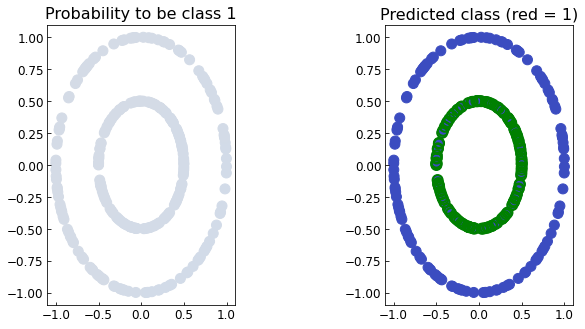

In [32]:
all_X_test = test_loader.dataset.data
all_targets_test = test_loader.dataset.targets

plot_results(net, all_X_test, all_targets_test)
print(f'accuracy is {accuracy(net, all_X_test, all_targets_test)*100:.2f} %')

Now let's train the network and track the evolution of the loss.

In [33]:
train_loss_list = []
test_accuracy_list = []

Here choose the learning rate and number of epochs

In [34]:
learning_rate = 0.01
n_epochs = 20

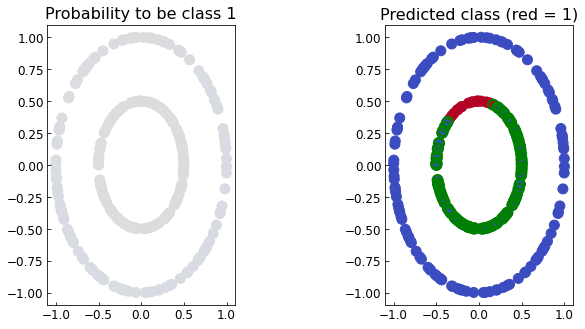

Epoch 0 loss: 0.6901810169219971, accuracy: 57.20 %


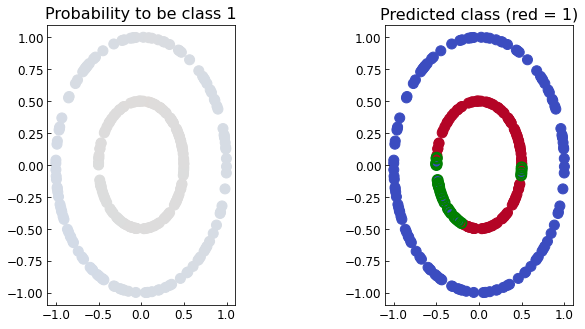

Epoch 1 loss: 0.6776873469352722, accuracy: 88.00 %


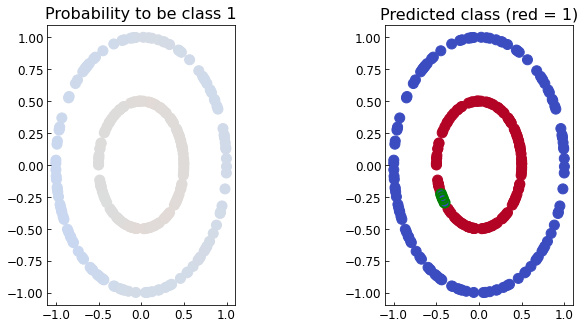

Epoch 2 loss: 0.6555569767951965, accuracy: 98.40 %


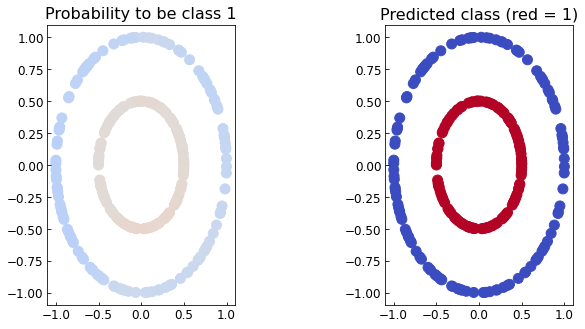

Epoch 3 loss: 0.6153436303138733, accuracy: 100.00 %


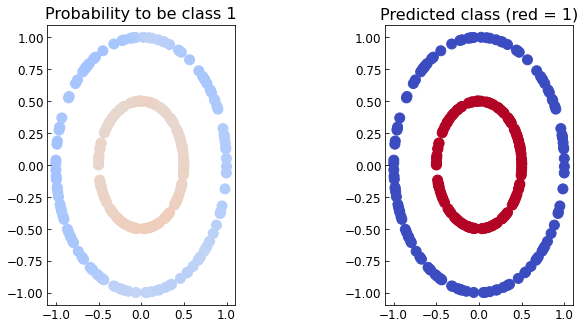

Epoch 4 loss: 0.5509666204452515, accuracy: 100.00 %


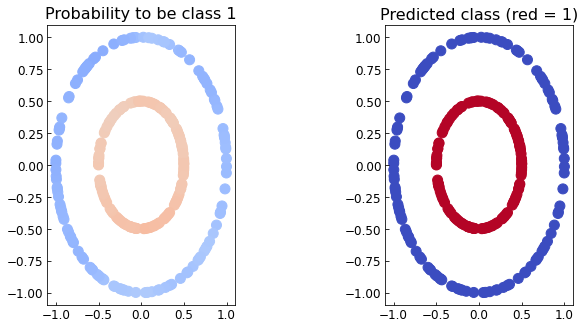

Epoch 5 loss: 0.4642266035079956, accuracy: 100.00 %


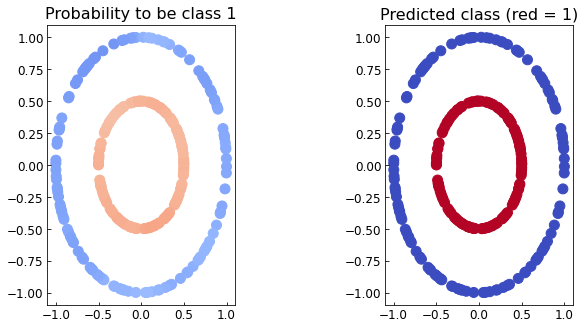

Epoch 6 loss: 0.3687765598297119, accuracy: 100.00 %


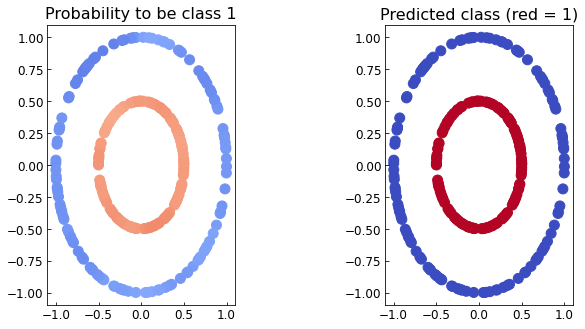

Epoch 7 loss: 0.2815379500389099, accuracy: 100.00 %


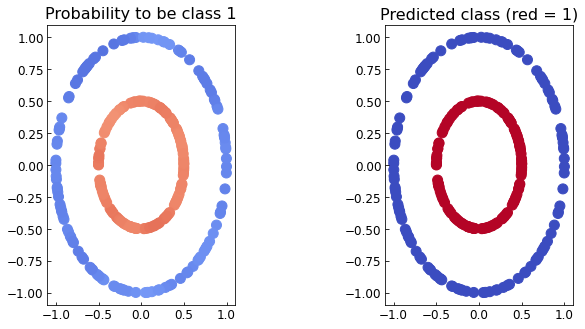

Epoch 8 loss: 0.21166716516017914, accuracy: 100.00 %


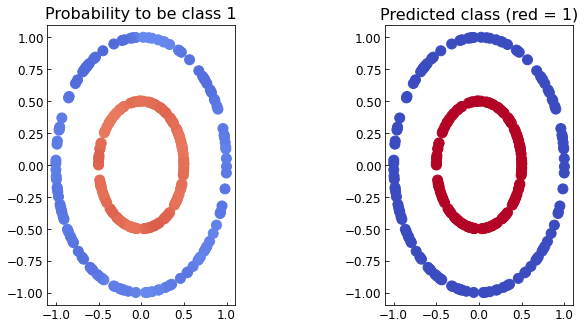

Epoch 9 loss: 0.159685418009758, accuracy: 100.00 %


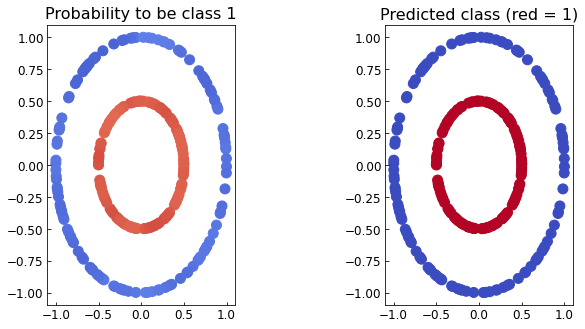

Epoch 10 loss: 0.1223837286233902, accuracy: 100.00 %


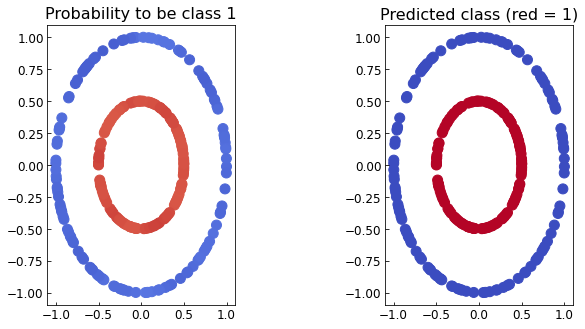

Epoch 11 loss: 0.09574957191944122, accuracy: 100.00 %


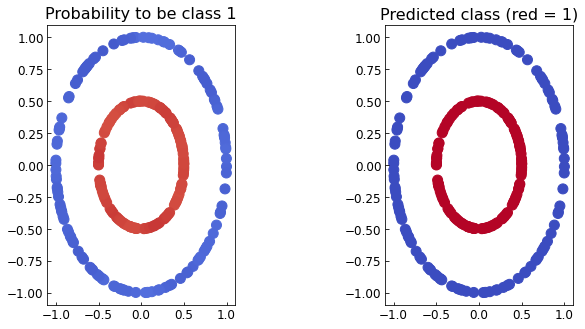

Epoch 12 loss: 0.07656870782375336, accuracy: 100.00 %


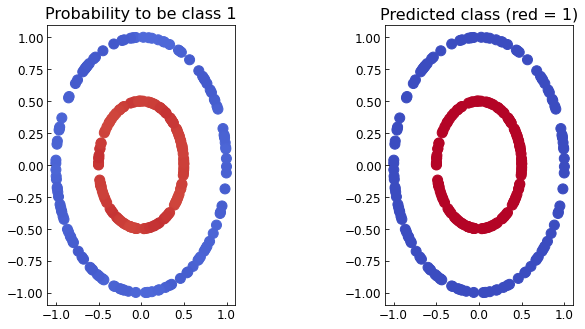

Epoch 13 loss: 0.06252587586641312, accuracy: 100.00 %


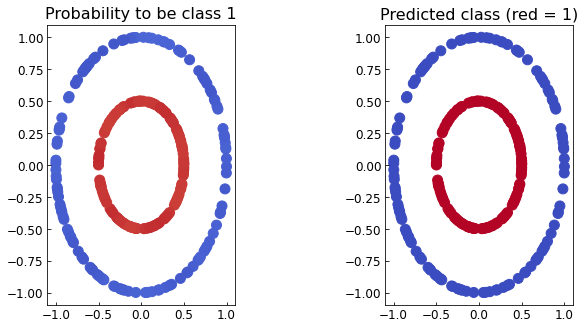

Epoch 14 loss: 0.05204539746046066, accuracy: 100.00 %


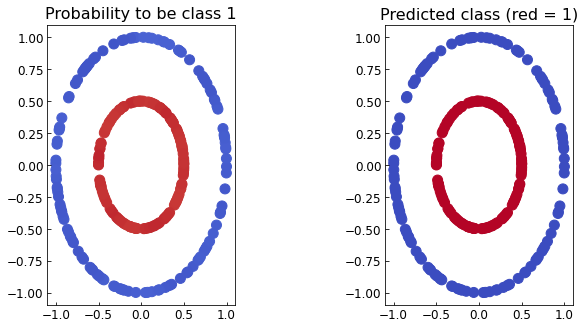

Epoch 15 loss: 0.044066548347473145, accuracy: 100.00 %


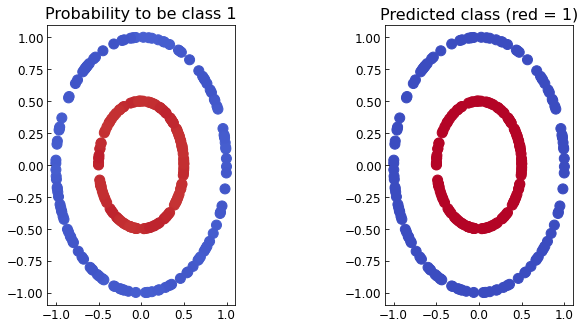

Epoch 16 loss: 0.03786619007587433, accuracy: 100.00 %


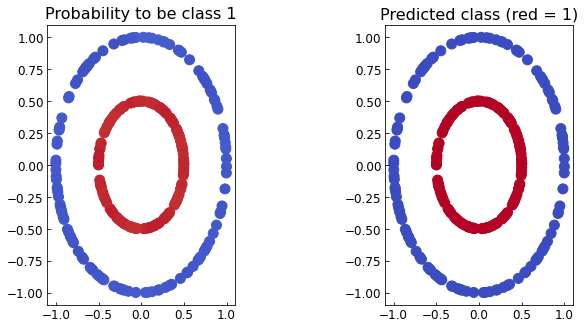

Epoch 17 loss: 0.0329599529504776, accuracy: 100.00 %


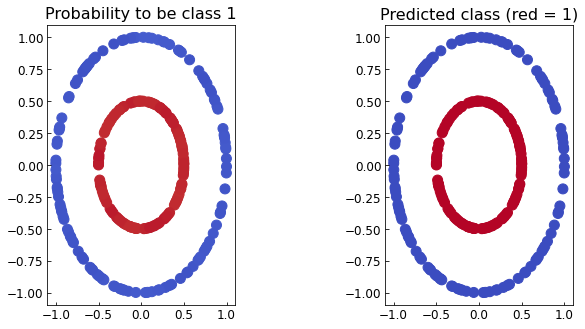

Epoch 18 loss: 0.029012473300099373, accuracy: 100.00 %


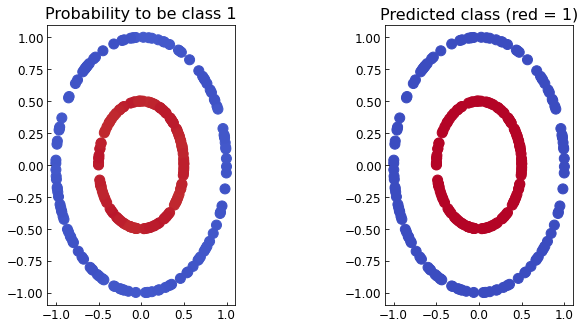

Epoch 19 loss: 0.02578934282064438, accuracy: 100.00 %


In [35]:
for epoch in range(n_epochs):
    loss = 0
    for idx in range(len(train_loader)):
        data = train_loader.dataset.data[idx]
        target = train_loader.dataset.targets[idx]
        loss += net.compute_grad(data, target)/len(train_loader)
        net.update_params(learning_rate = learning_rate)
    train_loss_list.append(loss)
    
    test_acc = accuracy(net, all_X_test, all_targets_test)*100
    test_accuracy_list.append(test_acc)
    plot_results(net, all_X_test, all_targets_test)
    plt.show()
    print(f'Epoch {epoch} loss: {loss}, accuracy: {test_acc:.2f} %')

Text(0.5, 0.98, 'Training a perceptron')

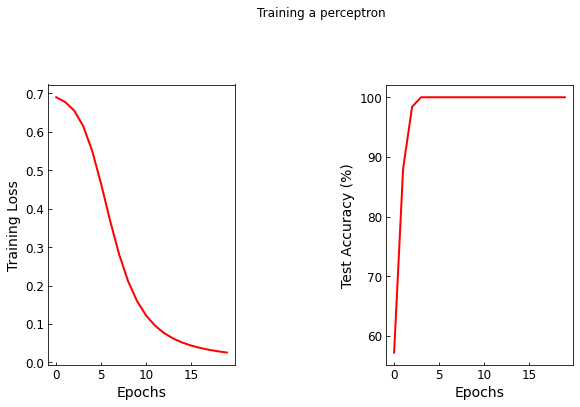

In [36]:
plt.style.use('plot_style.mplstyle')  # A file with parameters on what you want the figure to look like
fig, ax = plt.subplots(1, 2)  # a figure with 1 row and 2 columns of subplots
# fig is the figure itself, ax is an array of two independent subplots inside fig
# on the left side, plot the losses. 
ax[0].plot(train_loss_list, c='red', ls='-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Loss')
# on the right side, plot the accuracies. 
ax[1].plot(test_accuracy_list, c='red')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Test Accuracy (%)')
# We put a title for our figure.
fig_title = f'Training a perceptron'
fig.suptitle(fig_title)

In [ ]:
plot_results(net, all_X_test, all_targets_test)